In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import urllib

import rioxarray # for the extension to load
import xarray
import rasterio
import geopandas as gpd
#import xrspatial as xrs
from rasterstats import zonal_stats
import rasterstats
import platform
import requests
import sys
import datetime
import os

import argparse
import re
from typing import Sequence

import dask
import pandas as pd
import rioxarray  # noqa: F401  (side‑effect: registers .rio accessor)
import xarray as xr
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import pathlib

import pyproj
from pyproj import Proj
#import simplekml

import netCDF4
import warnings
warnings.simplefilter("ignore") 
#from geocube.api.core import make_geocube

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])
print(datetime.datetime.today())

Operating System Windows 11
Python Version 3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:37:28) [MSC v.1942 64 bit (AMD64)]
Pandas Version 2.2.3
Numpy Version 2.2.2
Matplotlib Version 3.10.0
py313
2025-07-26 11:12:59.426117


In [5]:
et_raster_dir = Path(r"G:\My Drive\OpenET Exports")

In [6]:

main_path = Path(r"G:\Shared Drives\UGS_Flux\Projects_and_Proposals\Castledale_ET")#watersheds_w_valley.shp
gis_path = main_path / "GIS"

input_dir = Path("G:/My Drive/OpenET Exports")
pattern = "*ee*.tif"


In [7]:
zones_bounds = gpd.read_file(gis_path / 'watersheds_w_valley.shp')
zones_bounds_wgs = zones_bounds.to_crs('epsg:4326')
zones_bounds_wgs['Acres'] =zones_bounds_wgs.to_crs('epsg:5070').geometry.area*0.000247105

zones_wrlu = gpd.read_file(gis_path / 'zonal_table.geojson')#"C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/WRLU_for_ET_Est.shp")
zones_wrlu['ID'] = zones_wrlu.index
zones_wrlu_wgs = zones_wrlu.to_crs('epsg:4326')
zones_wrlu_wgs['Acres'] =zones_wrlu.to_crs('epsg:5070').geometry.area*0.000247105

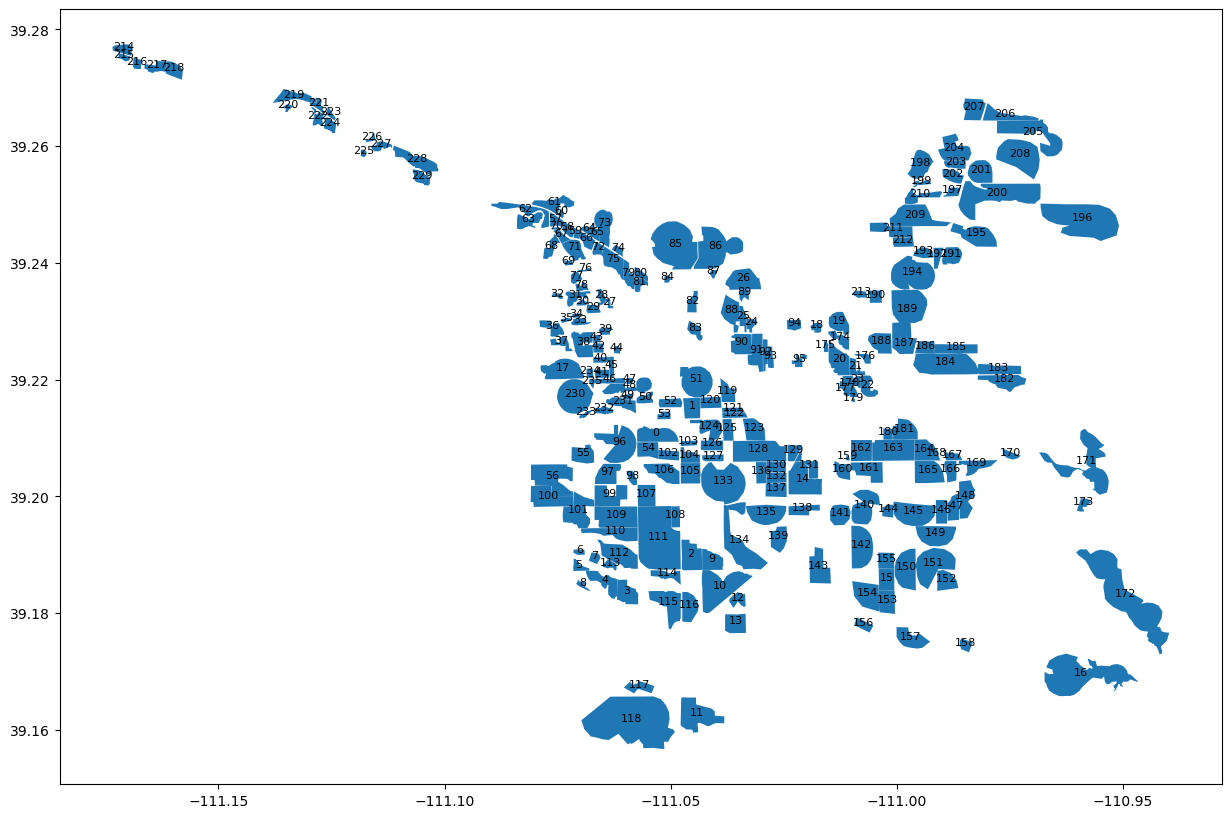

In [15]:
ax = zones_wrlu_wgs.plot()

# Using centroids for label placement
zones_wrlu_wgs['coords'] = zones_wrlu_wgs['geometry'].apply(lambda x: x.centroid.coords[0])

for idx, row in zones_wrlu_wgs.iterrows():
    ax.annotate(text=int(row['zonal_id']), xy=row['coords'],
                horizontalalignment='center', fontsize=8)

In [48]:

yr_total_bounds = {}
yr_total_basin = {}


for rasterfile in et_raster_dir.glob("eemetric*.tif"):
    yr = str(rasterfile.stem).split("_")[2]
    mo = str(rasterfile.stem).split("_")[3]
    day = str(rasterfile.stem).split("_")[4]
    date = pd.to_datetime(f"{yr}{mo}{day}", format=date_fmt)
    print(rasterfile.stem)
    zs_bounds = zonal_stats(zones_bounds_wgs, rasterfile, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']
    zs_basin = zonal_stats(zones_wrlu_wgs, rasterfile, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']

    total_bounds = {}
    for i in range(len(zones_bounds_wgs.geometry.area)):
        area_bounds = zones_bounds_wgs.loc[i,'Acres']
        p_meas_bounds = zs_bounds[i]['mean'] * 0.0393701 * 0.0833333 # in to meters
        total_bounds[zones_bounds_wgs.loc[i,'UID']] = area_bounds*p_meas_bounds#*0.000810714

    total_wrlu = {}
    for i in range(len(zones_wrlu_wgs.geometry.area)):
        area_basin = zones_wrlu_wgs.loc[i,'Acres']
        if zs_basin[i]['mean'] is None:
            p_meas_basin = 0
        else:
            p_meas_basin = zs_basin[i]['mean'] * 0.0393701 * 0.083333 # in to ft
        total_wrlu[zones_wrlu.loc[i,'ID']] = area_basin*p_meas_basin#*0.000810714

    yr_total_bounds[date] = total_bounds
    yr_total_basin[date] = total_wrlu
    print(date)


    


eemetric_et_2023_05_01_43fe8
2023-05-01 00:00:00
eemetric_et_2023_05_15_933ac
2023-05-15 00:00:00
eemetric_et_2023_05_16_d4efb
2023-05-16 00:00:00
eemetric_et_2023_05_17_ca27a
2023-05-17 00:00:00
eemetric_et_2023_05_18_401c8
2023-05-18 00:00:00
eemetric_et_2023_05_20_8573b
2023-05-20 00:00:00
eemetric_et_2023_05_19_bd4d0
2023-05-19 00:00:00
eemetric_et_2023_05_21_78d5e
2023-05-21 00:00:00
eemetric_et_2023_05_22_da957
2023-05-22 00:00:00
eemetric_et_2023_05_23_5d9b1
2023-05-23 00:00:00
eemetric_et_2023_05_24_a656d
2023-05-24 00:00:00
eemetric_et_2023_05_25_4cd91
2023-05-25 00:00:00
eemetric_et_2023_05_26_34d18
2023-05-26 00:00:00
eemetric_et_2023_05_27_37373
2023-05-27 00:00:00
eemetric_et_2023_05_29_11f16
2023-05-29 00:00:00
eemetric_et_2023_05_28_4f22c
2023-05-28 00:00:00
eemetric_et_2023_05_30_cc660
2023-05-30 00:00:00
eemetric_et_2023_05_31_db87f
2023-05-31 00:00:00
eemetric_et_2023_05_01_8de09
2023-05-01 00:00:00
eemetric_et_2023_05_02_53015
2023-05-02 00:00:00
eemetric_et_2023_05_

In [54]:
watersheds = pd.DataFrame(yr_total_bounds).T
wrlu = pd.DataFrame(yr_total_basin).T

In [56]:
watersheds.to_parquet("watershed_daily_eemetric.parquet")
wrlu.to_parquet("wrlu_daily_eemetric.parquet")

In [8]:
watershed = pd.read_parquet("watershed_daily_eemetric.parquet")
wrlu = pd.read_parquet("wrlu_daily_eemetric.parquet")

,1,2,3,4,5,6,7,8,9,10,...,42,43,44,45,46,47,48,49,50,51
2023-05-01,2308.326674,2063.072951,2467.124761,1227.564269,2292.850873,1889.264385,1074.262356,1659.478916,5343.685252,1187.979363,...,1245.020607,480.000583,133.371720,372.391612,17.413657,7.216206,35.834539,164.187325,66.351574,865.964316
2023-05-15,1494.500799,1514.103717,2203.698594,1202.183105,1894.559996,1469.849158,812.121786,1132.804260,4342.329394,1044.298380,...,916.717156,365.025654,92.597275,259.644633,12.367610,5.126567,25.369102,107.322785,39.029777,568.026476
2023-05-16,1603.828185,1613.163621,2400.446789,1292.366172,2026.555409,1605.407777,877.359113,1223.007038,4836.751899,1127.304270,...,983.188506,393.068359,99.911472,274.980073,12.872214,5.335530,26.519918,113.774040,41.419353,615.324752
2023-05-17,1717.186973,1700.042353,2476.628014,1375.116573,2156.019701,1645.450043,928.127657,1291.259897,4753.171557,1197.289324,...,1019.898284,415.461050,105.406533,292.864097,13.881423,5.753458,28.687256,123.185533,45.012662,642.836552
2023-05-18,1698.260818,1674.417957,2389.087432,1364.425953,2137.943053,1593.060030,921.370486,1272.381219,4709.581344,1164.061274,...,1028.421919,411.706011,105.406533,290.731496,13.881423,5.753458,28.436783,119.753322,43.808933,636.516100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18,630.576204,875.065637,1332.806425,412.258004,923.609591,869.135423,457.003574,729.640747,2533.556334,470.541234,...,699.361296,177.244306,62.334560,185.111037,8.394510,5.036547,12.793332,46.954166,16.097362,420.507487
2024-04-17,700.132908,956.693772,1483.630489,455.874509,997.717416,964.480547,492.222400,782.339608,2841.714550,507.659798,...,780.161969,197.525206,68.328285,202.846035,8.984416,5.392994,13.921272,51.300444,17.576301,465.814212
2024-04-15,535.249555,679.626834,1033.056379,347.401803,750.864249,677.824201,365.367961,587.497538,2001.132938,390.815040,...,589.028143,148.007059,50.169098,147.565859,6.643036,3.988965,10.421757,38.067124,13.139484,335.601239
2024-04-16,630.818030,899.462437,1397.912801,412.607532,908.130667,896.650861,443.871478,702.194793,2611.972471,452.090524,...,717.988767,181.119367,64.887888,189.250829,8.399072,5.041988,13.026514,47.457638,16.097362,438.328162
